In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Team: Nithin Varghese Ninan, Gladson S, Malini S, Asutosh Satapathy, Prasanna

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import json
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from IPython.display import display, Math, Latex
import seaborn as sns
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/Dataset_Agreement.pdf


In [2]:
def readjson(filepath):
    data = []
    i=0
    with open(filepath,encoding="utf8") as f:
            for line in f:
                 if i<200000:
                    data.append(json.loads(line))
                    #print(i)
                    i +=1
    return pd.DataFrame(data)

business_df = readjson('/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json')
review_df = readjson('/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json')
user_df = readjson('/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json')
checkin_df = readjson('/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json')
tip_df = readjson('/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json')

In [3]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


<AxesSubplot:>

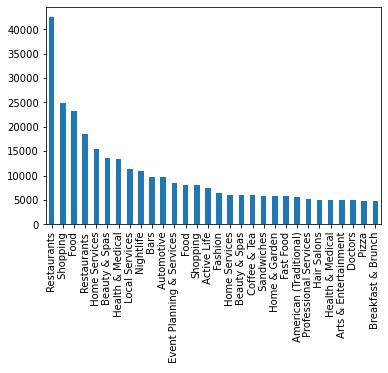

In [4]:

uniq_cat_dict = {}
for i in business_df.categories:
    cat = str(i).split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar')


<AxesSubplot:>

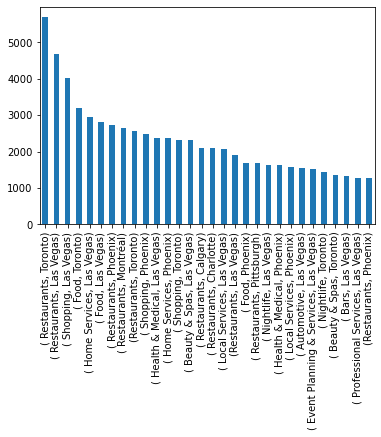

In [5]:
business_city = {}
n = len(business_df)
for i in range(n):
    k1 = str(business_df.categories.iloc[i]).split(',')
    k2 = business_df.city.iloc[i]
    for j in k1:
        k = (j,k2)
        if k not in business_city.keys():
            business_city[k] = 1
        else:
            business_city[k] += 1
business_city_series = pd.Series(business_city)
business_city_series.sort_values(ascending = False, inplace = True)
business_city_series[:30].plot(kind = 'bar')

In [6]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [7]:
df_reduced_review = review_df.drop(['text','useful','cool', 'date', 'funny'], axis = 1)
df_reduced_review.head()

,review_id,user_id,business_id,stars
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0


In [8]:
df_merged = df_reduced_review.merge(business_df[['city','categories', 'business_id']], how = 'outer', on= 'business_id')
df_merged.head()

,review_id,user_id,business_id,stars,city,categories
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
1,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
2,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
3,sLkT7J06L4TK4PiRUFax2g,AXuHgGQoNPkiSXTxHlQc0A,-MhfebM0QIsKt87iDN-FNw,2.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
4,cnV5xtm6WuyaLfot9uWbDg,LkWNo83Lg92C5V4JEyxOZA,-MhfebM0QIsKt87iDN-FNw,3.0,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."


In [9]:
df_cleaned = df_merged.dropna()
df_cleaned.shape

(199967, 6)

In [10]:
def topm_num_reviews_for_city_n_biz(df,m):
    business_city_count = {}
    n = len(df)
    for i in range(n):
        k1 = str(df.categories.iloc[i]).split(',')
        k2 = df.city.iloc[i]
        for j in k1:
            k = (j,k2)
            if k not in business_city_count.keys():
                business_city_count[k] = 1
            else:
                business_city_count[k] += 1
    business_city_count_series = pd.Series(business_city_count)
    business_city_count_series.sort_values(ascending = False, inplace = True)
    return business_city_count_series

<AxesSubplot:>

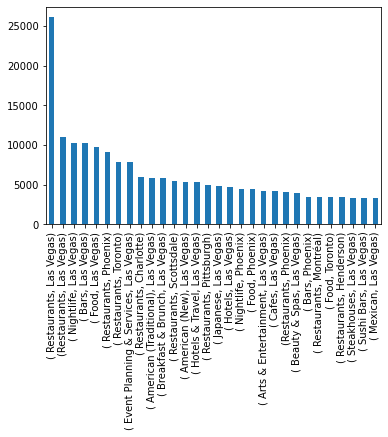

In [11]:
review_business_city = topm_num_reviews_for_city_n_biz(df_cleaned,10)
review_business_city[:30].plot(kind = 'bar')

In [12]:
rest_reviews = df_cleaned[(df_cleaned.categories.str.contains('.Restaurant.', case= False))]
print(rest_reviews)


                     review_id                 user_id  \
209     6TdNDKywdbjoTkizeMce8A  UgMW8bLE0QMJDCkQ1Ax5Mg   
210     gQuXBrYo8dqY7h_rfDzwLw  46TNf-5T5EcNFRJPYv_nrw   
211     xkq0ekkZ39uSbb29LihkfQ  OTGWjBCELxkZ6lpS2OEtxQ   
212     m4AkgxXvb-GHuDK4b9i9sA  YvlcRfeulgtusMFBOQTWzw   
213     OkgQVoHBJ6w-4qL-9lOczA  DBq1YkbIJ4yTXUYJw1V_KA   
...                        ...                     ...   
199981  HAZvUmjiKAHiKaN8PEeCdA  FP-OWNA7iYmmMvZ4cWuHpw   
199992  MN40rv69G4HEXn32z5kbAA  e9ORag2R3uYNLPU-SZ7Nbg   
199993  0bNRc6OcEmYQeMAzQWMFcA  PxWy8hQCzaK8nO3Q0dF3mg   
199996  9DNxmiQ6aMKMkvGm3C8WQA  D72xrqJCykVKEQgpBg0eKw   
199999  bwL_hepo712ubw288ukY0A  WR4OEbuqbbdnrR-9QARcSg   

                   business_id  stars       city  \
209     IS4cv902ykd8wj1TR0N3-A    4.0  Henderson   
210     IS4cv902ykd8wj1TR0N3-A    4.0  Henderson   
211     IS4cv902ykd8wj1TR0N3-A    3.0  Henderson   
212     IS4cv902ykd8wj1TR0N3-A    1.0  Henderson   
213     IS4cv902ykd8wj1TR0N3-A    3.0  Hend

In [13]:
rest_toronto_reviews = df_cleaned[(df_cleaned.city == 'Toronto') & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_toronto_reviews.head()


,review_id,user_id,business_id,stars,city,categories
2722,mM8i91yWP1QbImEvz5ds0w,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4.0,Toronto,"Pizza, Italian, Salad, Restaurants"
2723,JFSu748xDxsT3SSeEKc5pg,Nq6e5N8bjgD9B46O4va_zA,qUWqjjjfpB2-4P3He5rsKw,4.0,Toronto,"Pizza, Italian, Salad, Restaurants"
2724,uQ1ECZKa24lHUov_BsXfVg,wPLEzIlIUnTgc0lkJL_TmQ,qUWqjjjfpB2-4P3He5rsKw,4.0,Toronto,"Pizza, Italian, Salad, Restaurants"
2725,Fg5giQo4w776Q2NgHe4jIw,TX5kwQLpKUDvNf4mfdaH3Q,qUWqjjjfpB2-4P3He5rsKw,5.0,Toronto,"Pizza, Italian, Salad, Restaurants"
2726,efL6dh7WnJT9wIPs2raulg,fSYQ_oQ0wNGk2nMJLvNZJA,qUWqjjjfpB2-4P3He5rsKw,5.0,Toronto,"Pizza, Italian, Salad, Restaurants"


In [14]:
#rest_toronto_reviews.dtypes
#unique_users = list(rest_toronto_reviews['user_id'].unique())
#unique_bus = list(rest_toronto_reviews['business_id'].unique())

In [15]:
#rest_toronto_reviews['user_id'] = pd.Categorical(rest_toronto_reviews['user_id'], categories=unique_users, ordered=True)
#rest_toronto_reviews['business_id'] = pd.Categorical(rest_toronto_reviews['business_id'], categories=unique_bus, ordered=True)
#print(rest_toronto_reviews['user_id'])

In [16]:
def get_clean_df(df, min_user_review = 10, min_res_review = 0, cols = ['user_id', 'business_id', 'stars']):
    '''Cleans the df and gets rid of the unwanted cols and also allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new[cols[1]+'_freq'] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_clean = df_new[df_new[cols[1]+'_freq']>=min_res_review]
    df_clean[cols[0]+'_freq'] = df_clean.groupby(cols[0])[cols[0]].transform('count')
    df_clean_2 = df_clean[df_clean[cols[0]+'_freq']>=min_user_review]
    return df_clean_2

In [17]:
from scipy.sparse import csr_matrix
def get_sparsity(sparse_matrix):
    return 1 - sparse_matrix.nnz/(sparse_matrix.shape[0]*sparse_matrix.shape[1])

In [18]:
unique_users = list(rest_toronto_reviews['user_id'].unique())
unique_bus = list(rest_toronto_reviews['business_id'].unique())
print(unique_users)
print(unique_bus)

['TZQSUDDcA4ek5gBd6BzcjA', 'Nq6e5N8bjgD9B46O4va_zA', 'wPLEzIlIUnTgc0lkJL_TmQ', 'TX5kwQLpKUDvNf4mfdaH3Q', 'fSYQ_oQ0wNGk2nMJLvNZJA', 'xtVSuW9H_Sfl_MvcZ8O0dg', 'aAEHXLLi-W14AHavfJB5sw', 'izdAXYjPdwaztxuT6C7GvQ', '6MsHD7EbrjT6COvOeoBeUQ', 'Is5JcD_-zLKcBMK0anhZvg', 'WSbu_utXtbm49IWVzvE0gQ', 'XrYTMhY9YJvzX2pMepIz7A', 'P7S6JorjpamxAVSvmrmjXw', '1Mm0Q8lEmFXF-WKLgSKQTw', '-1g1OCAmYUjkRgk8tcUMBA', 'q4O6ty6-tMeG1nc0Vi4hAw', 'sMbndZjfdDOz4ewzn1K6eg', '5XNQxpfIRCAYLsTnGANJ_w', 'rFEtLuBt7vEu8_IsKfLmTA', 'awcDbvJX9GLVdFBHO0alKg', 'RuWJiPEVUvlJb3TZ2zSdfA', 'niF7QWkPJgfM9AxLqSigyw', 'L0JvK1BtEe5Yz_rmclfcQA', 'fq-3XQ3js32rRqTBBr4i_A', 'EIGFolTH-WFtZhJiX1qSLA', 'jTOeivxEX9CdpXrdcMeiAA', 'L_UhHIpOaA9ic3Wxg3_seQ', 'YOOsYiXGEtGFX_wSeZNcww', 'GRIQKo8gEGJRsfq2UdQSfQ', 'X94xZDL2yd2AUHNln_Mxug', 'A74HvikXkReiHptcJGAo2Q', 'JsJ62J_TFXrTRvwuoX1DYw', 'JoHicqF3jm5IF79LlXuBqQ', 'eRDWzHCldd6YXypRECvHYg', 'jkWwjJ4J46Cf2jK54NSnEg', '90Pr-CoLH5X1e9inQIt8bQ', 'Ul94YQ3mFJDCj1oOvV8gHA', 'pAH0GRL9uBTEqzuRAzOQLA', 'f_-0PP72bm

In [19]:
from pandas.api.types import CategoricalDtype
def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['stars'].tolist()
    #row = df['user_id'].astype('category', categories =unique_users).cat.codes
    #row = pd.Categorical(df['user_id'], categories=unique_users, ordered=True)
    #col = pd.Categorical(df['business_id'], categories=unique_bus, ordered=True)
    df['user_id'] = df['user_id'].astype('category')
    df['business_id'] = df['business_id'].astype('category')
    row = df['user_id'].cat.codes
    col = df['business_id'].cat.codes
    #row = df['user_id'].astype('category', categories=unique_users).cat.codes
    #col = df['business_id'].astype('category', categories=unique_bus).cat.codes
    #col = df['business_id'].astype('category', categories =unique_bus).cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix

In [20]:
user_min_10_toronto_res = get_clean_df(rest_toronto_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Toronto: ", user_min_10_toronto_res.shape[0])

Number of Reviews for Restaurants in Toronto:  107


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [21]:
user_min_10_toronto_res.head()

,user_id,business_id,stars,business_id_freq,user_id_freq
4691,m5b84-nPPVNLlDtZyVGZ3w,9Eghhu_LzEJgDKNgisf3rg,3.0,153,13
4701,FREeRQtjdJU83AFtdETBBw,9Eghhu_LzEJgDKNgisf3rg,5.0,153,13
13666,gwIqbXEXijQNgdESVc07hg,jM6JjZXFAQQANwdlEwbH3g,2.0,14,13
20600,JnPIjvC0cmooNDfsa9BmXg,nY2oBwH3s5sKox1mERIoVQ,5.0,24,11
22990,m5b84-nPPVNLlDtZyVGZ3w,tWdp26XQEJqJGnRmFVJQxA,4.0,64,13


In [22]:
def get_sparsity(sparse_matrix):
    return 1 - sparse_matrix.nnz/(sparse_matrix.shape[0]*sparse_matrix.shape[1])

In [23]:
sm_user_10_toronto_rest = get_sparse_matrix(user_min_10_toronto_res)
print("Shape of ratings matrix for Restaurants in Toronto =",sm_user_10_toronto_rest.shape)

Shape of ratings matrix for Restaurants in Toronto = (8, 76)


In [24]:
sparsity_toronto = 1 - sm_user_10_toronto_rest.nnz/(sm_user_10_toronto_rest.shape[0]*sm_user_10_toronto_rest.shape[1])
print("Sparsity of ratings matrix for Restaurants in Toronto = ", sparsity_toronto)

Sparsity of ratings matrix for Restaurants in Toronto =  0.8305921052631579


In [25]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [26]:
sm_u_10_trt_res_train, sm_u_10_trt_res_val, sm_u_10_trt_res_test =  train_val_test_split(sm_user_10_toronto_rest)

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [27]:
print(sm_u_10_trt_res_train.nnz, sm_u_10_trt_res_val.nnz, sm_u_10_trt_res_test.nnz)

71 16 16


In [28]:
u_10_trt = get_sparse_matrix(get_clean_df(rest_toronto_reviews, min_user_review=10))
print(get_sparsity(u_10_trt))
print(u_10_trt.shape)
u_10_train, u_10_val, u_10_test = train_val_test_split(u_10_trt, num_review_val= 7, num_review_test= 3)

0.8305921052631579
(8, 76)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [29]:
def similarity_matrix(train_matrix, between = 'users'):
    '''Returns the cosine similarity between users or restaurants'''
    if between == 'users':
        similarity = train_matrix*train_matrix.transpose()
    else:
        similarity = train_matrix.transpose()*train_matrix
    similarity_dense = similarity.todense() + 1e-8
    norm_array = np.sqrt(np.diag(similarity_dense))
    return similarity_dense/norm_array/norm_array.reshape(-1,1)

In [30]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = np.mean(ratings, axis =1)
        ratings = (ratings - np.tile(user_bias, (ratings.shape[1],1)).T).copy()
        for i in range(ratings.shape[0]):
            top_k_users = np.argsort(similarity[:,i])[:-k-1:-1]
            pred[i] = np.dot(similarity[i,top_k_users],ratings[top_k_users,:])/np.sum(np.abs(similarity[i,top_k_users]))
        pred += np.tile(user_bias,(ratings.shape[1],1)).T
    else:
        item_bias = np.mean(ratings, axis=0)
        ratings = (ratings - np.tile(item_bias,(ratings.shape[0],1))).copy()
        for j in range(ratings.shape[1]):
            top_k_items = np.argsort(similarity[:,j])[:-k-1:-1]
            pred[:,j] = np.dot(similarity[top_k_items,j].T,ratings[:,top_k_items].T)/np.sum(np.abs(similarity[top_k_items,j]))
        pred += np.tile(item_bias,(ratings.shape[0],1))
        
    return pred

In [31]:
from sklearn.metrics import mean_squared_error
def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [32]:
simi_trt_res = similarity_matrix(sm_u_10_trt_res_train, between='res')
simi_trt_res = np.array(simi_trt_res)
preds_cosine_trt = predict_topk_nobias(np.array(sm_u_10_trt_res_train.todense()),simi_trt_res,kind='res', k=1)
MSE_cosine_res = get_mse(preds_cosine_trt, np.array(sm_u_10_trt_res_val.todense()))
print("MSE for cosine Similarity between Restaurants =",MSE_cosine_res)

MSE for cosine Similarity between Restaurants = 19.25


In [33]:
simi_trt_users = similarity_matrix(sm_u_10_trt_res_train, between='users')
simi_trt_users = np.array(simi_trt_users)
preds_cosine_trt_users = predict_topk_nobias(np.array(sm_u_10_trt_res_train.todense()),simi_trt_users,kind='user', k=1)
MSE_cosine_users = get_mse(preds_cosine_trt_users, np.array(sm_u_10_trt_res_val.todense()))
print("MSE for cosine Similarity between Users =",MSE_cosine_users)

MSE for cosine Similarity between Users = 19.25


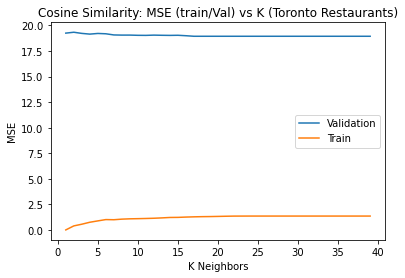

In [34]:
errors_cs_res_trt_val = {}
errors_cs_res_trt_train = {}
k_cs = np.arange(1, 40)
simi_trt_res = similarity_matrix(sm_u_10_trt_res_train, between='res')
simi_trt_res = np.array(simi_trt_res)
for i in k_cs:
    preds_cs_res_trt = predict_topk_nobias(np.array(sm_u_10_trt_res_train.todense()),simi_trt_res,kind='res', k=i)
    error_cs_val = get_mse(preds_cs_res_trt, np.array(sm_u_10_trt_res_val.todense()))
    error_cs_train = get_mse(preds_cs_res_trt, np.array(sm_u_10_trt_res_train.todense()))
    errors_cs_res_trt_val[i] = error_cs_val
    errors_cs_res_trt_train[i] = error_cs_train
plt.plot(errors_cs_res_trt_val.keys(),errors_cs_res_trt_val.values(), label = 'Validation')
plt.plot(errors_cs_res_trt_train.keys(),errors_cs_res_trt_train.values(), label = 'Train')
plt.xlabel('K Neighbors')
plt.ylabel('MSE')
plt.title('Cosine Similarity: MSE (train/Val) vs K (Toronto Restaurants)')
plt.legend()

In [35]:
preds_cosine_trt = predict_topk_nobias(np.array(sm_u_10_trt_res_train.todense()),simi_trt_res,kind='res', k=40)
Best_Val_MSE_Cosine_trt = get_mse(preds_cosine_trt, np.array(sm_u_10_trt_res_val.todense()))
print('Best Validation MSE for Cosine Similarity for Restaurants in Toronto= ', Best_Val_MSE_Cosine_trt)

Best Validation MSE for Cosine Similarity for Restaurants in Toronto=  18.942611938920187


In [36]:
train_trt_nnz = sm_u_10_trt_res_train.nonzero()
val_trt_nnz = sm_u_10_trt_res_val.nonzero()
test_trt_nnz = sm_u_10_trt_res_test.nonzero()

In [37]:
train_preds_cosine_trt = preds_cosine_trt[train_trt_nnz]
val_preds_cosine_trt = preds_cosine_trt[val_trt_nnz]
test_preds_cosine_trt = preds_cosine_trt[test_trt_nnz]

In [38]:
def sgd(ratings, k=40, user_bias_reg = 0.01, res_bias_reg = 0.01, user_vec_reg = 0.01, res_vec_reg = 0.01, lr = 1e-3, 
       iterations = 200):
    '''Learn user and res biases along with latent vectors'''
    error_array = np.zeros(iterations);
    global_bias = np.mean(ratings[np.where(ratings)!=0])
    user_bias = 0.1*(2*(np.random.rand(ratings.shape[0]))-1)
    res_bias = 0.1*(2*(np.random.rand(ratings.shape[1]))-1)
    user_vec = 0.1*(2*(np.random.rand(ratings.shape[0],k))-1)
    res_vec = 0.1*(2*(np.random.rand(ratings.shape[1],k))-1)
    training_idx = np.arange(ratings.nonzero()[0].shape[0])
    np.random.shuffle(training_idx)
    nz_rows_idx = ratings.nonzero()[0]
    nz_cols_idx = ratings.nonzero()[1]
    for i in range(iterations):
    
#         if(i%20 == 0):
#             print('Iteration number: ', i)
        lr = 1.0/(100 + 0.01*i)
        np.random.shuffle(training_idx)
        
        temp_error_array = np.zeros(len(training_idx));
        for datapoint_i, idx in enumerate(training_idx):
            u = nz_rows_idx[idx]
            r = nz_cols_idx[idx]
            prediction = global_bias + user_bias[u] + res_bias[r] + np.dot(user_vec[u,:], res_vec[r,:].T)
            e = (ratings[u,r] - prediction);
            temp_error_array[datapoint_i] += e**2;
            if i > 0:
                user_bias[u] += lr * (e - user_bias_reg * user_bias[u])
                res_bias[r] += lr * (e - res_bias_reg * res_bias[r])
                user_vec[u,:] += lr * (e * res_vec[r,:] - user_vec_reg * user_vec[u,:])
                res_vec[r,:] += lr * (e * user_vec[u,:] - res_vec_reg * res_vec[r,:])
            
        error_array[i] = np.mean(temp_error_array);
#         print(error_array[i])
            
    predictions = global_bias + user_bias[:, np.newaxis] + res_bias[np.newaxis, :] + np.dot(user_vec, res_vec.T)
    predictions[predictions > 5] = 5
    predictions[predictions < 0] = 0
    
    return (predictions, error_array, user_vec, res_vec)

iters =  10
iters =  20
iters =  30
iters =  40


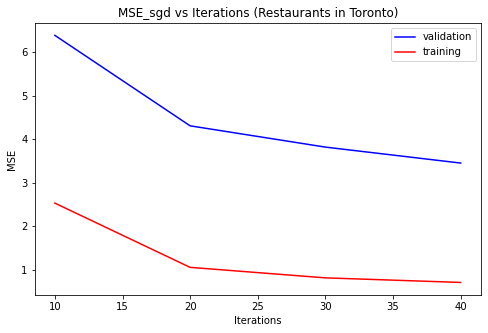

In [39]:
iters = np.arange(10, 50, 10)
err_sgd_test_trt = []
err_sgd_train_trt = []
for i in iters:
    print('iters = ',i)
    preds_sgd = sgd(np.array(sm_u_10_trt_res_train.todense()), k=10, iterations= i)
    err_test = get_mse(preds_sgd[0], np.array(sm_u_10_trt_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_trt_res_train.todense()))
    err_sgd_test_trt.append(err_test)
    err_sgd_train_trt.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(iters,err_sgd_test_trt,'b-',label = 'validation')
plt.plot(iters,err_sgd_train_trt,'r-', label = 'training')
plt.title('MSE_sgd vs Iterations (Restaurants in Toronto)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

k= 2
k= 3
k= 4
k= 6
k= 7
k= 9
k= 10
k= 12
k= 13
k= 15


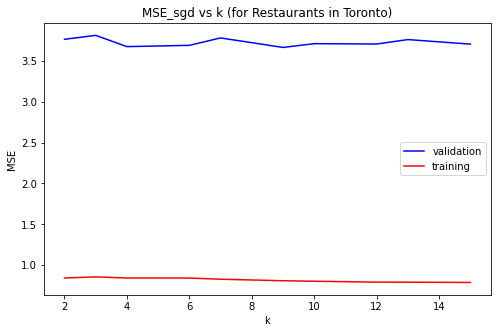

In [40]:
k = np.linspace(2, 15, 10, dtype = int)
err_sgd_val_trt = []
err_sgd_train_trt = []
for i in k:
    print('k=', i)
    preds_sgd = sgd(np.array(sm_u_10_trt_res_train.todense()), k=i, iterations= 30)
    err_val = get_mse(preds_sgd[0], np.array(sm_u_10_trt_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_trt_res_train.todense()))
    err_sgd_val_trt.append(err_val)
    err_sgd_train_trt.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(k,err_sgd_val_trt,'b-',label = 'validation')
plt.plot(k,err_sgd_train_trt,'r-', label = 'training')
plt.title('MSE_sgd vs k (for Restaurants in Toronto)')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()

In [41]:
predictions_sgd_trt, error_array_sgd_trt, user_vec_sgd_trt, res_vec_sgd_trt = sgd(np.array(sm_u_10_trt_res_train.todense()), k=2, iterations= 30)

In [42]:
preds_sgd_trt = sgd(np.array(sm_u_10_trt_res_train.todense()),k=2, iterations=30)
Best_Val_MSE_sgd_trt = get_mse(preds_sgd_trt[0], np.array(sm_u_10_trt_res_val.todense()))
print('Best Validation MSE for SGD for Restaurants in Toronto= ', Best_Val_MSE_sgd_trt)

Best Validation MSE for SGD for Restaurants in Toronto=  3.70563194174294


In [43]:
train_preds_sgd_trt = preds_sgd_trt[0][train_trt_nnz]
val_preds_sgd_trt = preds_sgd_trt[0][val_trt_nnz]
test_preds_sgd_trt = preds_sgd_trt[0][test_trt_nnz]

In [44]:
def build_ensemble_df(cosine, sgd):
    df =pd.DataFrame(sgd)
    df['Cosine'] = cosine
    df['SGD'] = sgd
    return df

In [45]:
ensemble_training_trt_df = build_ensemble_df(train_preds_cosine_trt, train_preds_sgd_trt)
ensemble_validation_trt_df = build_ensemble_df(val_preds_cosine_trt, val_preds_sgd_trt)
ensemble_testing_trt_df = build_ensemble_df(test_preds_cosine_trt, test_preds_sgd_trt)

In [46]:
y_train_trt = np.ravel(np.array(sm_u_10_trt_res_train[train_trt_nnz]))
y_val_trt = np.ravel(np.array(sm_u_10_trt_res_val[val_trt_nnz]))
y_test_trt = np.ravel(np.array(sm_u_10_trt_res_test[test_trt_nnz]))

In [47]:
from sklearn.linear_model import Ridge
lrr_trt = Ridge(alpha = 10000)
lrr_trt.fit(ensemble_training_trt_df.iloc[:,-3:], y_train_trt)
ensemble_val_pred_trt = lrr_trt.predict(ensemble_validation_trt_df.iloc[:,-3:])
MSE_ensemble_trt = get_mse(ensemble_val_pred_trt,y_val_trt)
print('MSE of the ensemble of Models for restaurants in Toronto = ', MSE_ensemble_trt)

MSE of the ensemble of Models for restaurants in Toronto =  2.4245124596293017


In [48]:
ensemble_test_pred_trt = lrr_trt.predict(ensemble_testing_trt_df.iloc[:,-3:])
MSE_test_trt = get_mse(ensemble_test_pred_trt,y_test_trt)
print('MSE of the ensemble of Models for restaurants in Toronto (test) = ', MSE_test_trt)

MSE of the ensemble of Models for restaurants in Toronto (test) =  0.8383590924432285


In [49]:
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,...,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",5,...,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",6,...,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018","3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",78,...,9,2,1,1,22,28,31,31,19,31


In [50]:
checkin_df.head()

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."


In [51]:
tip_df.head()

,user_id,business_id,text,date,compliment_count
0,hf27xTME3EiCp6NL6VtWZQ,UYX5zL_Xj9WEc_Wp-FrqHw,Here for a quick mtg,2013-11-26 18:20:08,0
1,uEvusDwoSymbJJ0auR3muQ,Ch3HkwQYv1YKw_FO06vBWA,Cucumber strawberry refresher,2014-06-15 22:26:45,0
2,AY-laIws3S7YXNl_f_D6rQ,rDoT-MgxGRiYqCmi0bG10g,Very nice good service good food,2016-07-18 22:03:42,0
3,Ue_7yUlkEbX4AhnYdUfL7g,OHXnDV01gLokiX1ELaQufA,It's a small place. The staff is friendly.,2014-06-06 01:10:34,0
4,LltbT_fUMqZ-ZJP-vJ84IQ,GMrwDXRlAZU2zj5nH6l4vQ,"8 sandwiches, $24 total...what a bargain!!! An...",2011-04-08 18:12:01,0


In [52]:
business_df['categories'] = business_df['categories'].astype(str)
restaurant_df = business_df[business_df['categories'].str.contains('Food')==True]
complete_df = restaurant_df.merge(rest_toronto_reviews,on='business_id').merge(user_df,on='user_id')

In [53]:
restaurant_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
8,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,404 E Green St,Champaign,IL,61820,40.110446,-88.233073,4.5,5,1,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Ethnic Food, Food Trucks, Specialty Food, Impo...","{'Monday': '11:30-14:30', 'Tuesday': '11:30-14..."
12,M_guz7Dj7hX0evS672wIwA,Chocolate Shoppe Ice Cream,2831 Parmenter St,Middleton,WI,53562,43.105310,-89.510142,3.5,6,1,"{'BikeParking': 'True', 'Caters': 'True', 'Whe...","Desserts, Food, Ice Cream & Frozen Yogurt","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
20,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,0,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",None
23,mKTq1T_IAplDpHUcMzOXkw,Tipsy Ryde,,Gastonia,NC,28054,35.252842,-81.152698,3.5,3,1,{'BusinessAcceptsCreditCards': 'True'},"Hotels & Travel, Transportation, Taxis, Beer, ...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
25,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,300 John Street,Thornhill,ON,L3T 5W4,43.820492,-79.398466,4.5,7,1,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","Japanese, Fast Food, Food Court, Restaurants",None


In [54]:
complete_df.head()

,business_id,name_x,address,city_x,state,postal_code,latitude,longitude,stars_x,review_count_x,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,8k62wYhDVq1-652YbJi5eg,Tim Hortons,90 Adelaide Street W,Toronto,ON,M5H 3V9,43.649859,-79.382060,3.0,8,...,0,0,1,0,5,14,7,7,10,6
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,90 Adelaide Street W,Toronto,ON,M5H 3V9,43.649859,-79.382060,3.0,8,...,0,1,0,0,4,11,7,7,7,0
2,qcqDjeirxvdgW5kQVkEwSA,The Red Room,444 Spadina Avenue,Toronto,ON,M5T 2G8,43.657070,-79.400153,3.0,135,...,0,1,0,0,4,11,7,7,7,0
3,tuTAKHUm7ErDRZ2Yll8LzQ,Completo,5 Coady Avenue,Toronto,ON,M4M 2Y9,43.662633,-79.334058,4.5,142,...,0,1,0,0,4,11,7,7,7,0
4,nqTvE7ivdU23oUWdI01tOA,Under The Table Restaurant,568 Parliament Street,Toronto,ON,M4X 1P8,43.667423,-79.369456,4.5,392,...,0,1,0,0,4,11,7,7,7,0


In [55]:
complete_df.columns

Index(['business_id', 'name_x', 'address', 'city_x', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count_x', 'is_open',
       'attributes', 'categories_x', 'hours', 'review_id', 'user_id',
       'stars_y', 'city_y', 'categories_y', 'name_y', 'review_count_y',
       'yelping_since', 'useful', 'funny', 'cool', 'elite', 'friends', 'fans',
       'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

In [56]:
restaurant_matrix = complete_df[['business_id','name_x','stars_x','review_count_x','user_id','stars_y','name_y','review_count_y','average_stars']]
restaurant_matrix = restaurant_matrix.sort_values( by=['stars_x','review_count_x'], ascending=False).head(500)
restaurant_matrix.head()

,business_id,name_x,stars_x,review_count_x,user_id,stars_y,name_y,review_count_y,average_stars
522,P0-oxpGOTqRYbXNUye0IFw,Pasta Pantry,5.0,15,RzSuQm4M15wwRcukqIAfXA,5.0,Camila,2,5.00
523,P0-oxpGOTqRYbXNUye0IFw,Pasta Pantry,5.0,15,AIi-_2nQkH1vcguw3SBWfQ,5.0,Jonathan,10,3.00
524,P0-oxpGOTqRYbXNUye0IFw,Pasta Pantry,5.0,15,IL1-dyCe_zSqhmt0ExL_Jg,5.0,Victoria,200,4.16
2324,pDKITbL0no7HPHFodv9jTQ,Golden Gecko Coffee,5.0,15,Ed7eipVLDWj967zsxUQ5QQ,5.0,K,132,3.85
2325,pDKITbL0no7HPHFodv9jTQ,Golden Gecko Coffee,5.0,15,qJZCiO3qSOygLLxzX8l1wg,5.0,Tim,199,3.97


In [57]:
restaurant_pivot = restaurant_matrix.pivot_table(index=['name_y'], columns=['name_x'],values='stars_y')
restaurant_pivot.head()

name_x,00 Gelato,Atlas Espresso Bar,Blaze Fast-Fire'd Pizza,Chinese Egg Waffle Vendor,Citizenry,Completo,El Cafecito Cafe,Extra Burger,Farm'r Eatery & Catering,Filosophy Pastry and Espresso Bar,...,Riddle Room,Sarajevo Grill & Meat,Scout & Cash Caffe,Speducci Mercatto,Starbucks,Sushi & BBbop,The Desert Rose Restaurant and Hookah Lounge,Umami Poke,Under The Table Restaurant,Zav Coffee Shop & Gallery
name_y,,,,,,,,,,,,,,,,,,,,,
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
A.M.,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aalia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
Abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN


In [58]:
restaurant_pivot.shape

(402, 27)

<AxesSubplot:xlabel='name_x', ylabel='name_x'>

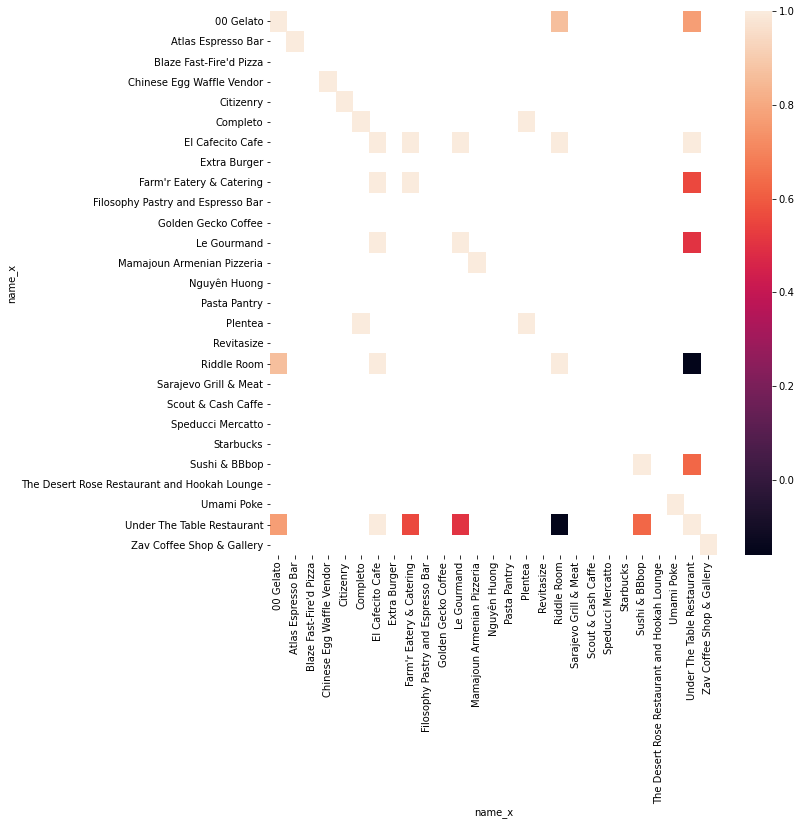

In [62]:
restaurant_similarity_df = restaurant_pivot.corr(method='pearson')
#restaurant_similarity_df
fig, ax = plt.subplots(figsize=(10,10)) # Sample figsize in inches
sns.heatmap(restaurant_similarity_df, xticklabels=restaurant_similarity_df.columns.values, yticklabels=restaurant_similarity_df.columns.values, ax=ax)

In [60]:
print(restaurant_similarity_df)

name_x                                        00 Gelato  Atlas Espresso Bar  \
name_x                                                                        
00 Gelato                                      1.000000                 NaN   
Atlas Espresso Bar                                  NaN                 1.0   
Blaze Fast-Fire'd Pizza                             NaN                 NaN   
Chinese Egg Waffle Vendor                           NaN                 NaN   
Citizenry                                           NaN                 NaN   
Completo                                            NaN                 NaN   
El Cafecito Cafe                                    NaN                 NaN   
Extra Burger                                        NaN                 NaN   
Farm'r Eatery & Catering                            NaN                 NaN   
Filosophy Pastry and Espresso Bar                   NaN                 NaN   
Golden Gecko Coffee                                 

In [64]:
def get_similar_restaurant(restaurant_name,user_rating):
    similar_score = restaurant_similarity_df[restaurant_name]*(user_rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score
print(get_similar_restaurant("Completo",4))

name_x
Completo                                        1.5
Plentea                                         1.5
00 Gelato                                       NaN
Atlas Espresso Bar                              NaN
Blaze Fast-Fire'd Pizza                         NaN
Chinese Egg Waffle Vendor                       NaN
Citizenry                                       NaN
El Cafecito Cafe                                NaN
Extra Burger                                    NaN
Farm'r Eatery & Catering                        NaN
Filosophy Pastry and Espresso Bar               NaN
Golden Gecko Coffee                             NaN
Le Gourmand                                     NaN
Mamajoun Armenian Pizzeria                      NaN
Nguyên Huong                                    NaN
Pasta Pantry                                    NaN
Revitasize                                      NaN
Riddle Room                                     NaN
Sarajevo Grill & Meat                           NaN
Scout

In [67]:
user1 = [("Completo",4)]

In [88]:
similar_restaurants = pd.DataFrame()
for restaurant,rating in user1:
    similar_restaurants=similar_restaurants.append(get_similar_restaurant(restaurant,rating), ignore_index=True)

similar_restaurants.head()
similar_restaurants.sum().sort_values(ascending=False)

Completo                                        1.5
Plentea                                         1.5
00 Gelato                                       0.0
Pasta Pantry                                    0.0
Under The Table Restaurant                      0.0
Umami Poke                                      0.0
The Desert Rose Restaurant and Hookah Lounge    0.0
Sushi & BBbop                                   0.0
Starbucks                                       0.0
Speducci Mercatto                               0.0
Scout & Cash Caffe                              0.0
Sarajevo Grill & Meat                           0.0
Riddle Room                                     0.0
Revitasize                                      0.0
Nguyên Huong                                    0.0
Atlas Espresso Bar                              0.0
Mamajoun Armenian Pizzeria                      0.0
Le Gourmand                                     0.0
Golden Gecko Coffee                             0.0
Filosophy Pa